# Graph RAG Implementation

## Overview
Graph RAG uses knowledge graphs instead of plain text chunks for retrieval. It creates a structured representation of information with entities and relationships, enabling more contextual and connected retrievals.

### Key Components:
- **Entity Extraction**: Identify key entities from documents
- **Relationship Mapping**: Define connections between entities
- **Graph Construction**: Build knowledge graph from extracted information
- **Graph Traversal**: Navigate the graph for retrieval

### Use Cases:
- Research paper analysis with citation networks
- Biomedical knowledge discovery
- Legal document relationships
- Academic literature review

### Analogy:
Reading a mind map - instead of linear text chunks, you navigate through connected concepts and relationships.

## Installation and Setup

In [ ]:
# Install required packages
!pip install -q langchain langchain-community
!pip install -q networkx spacy transformers
!pip install -q sentence-transformers chromadb
!pip install -q neo4j pandas matplotlib

# Download spaCy model for NLP
!python -m spacy download en_core_web_sm

In [6]:
import os
import pandas as pd
import networkx as nx
import spacy
import matplotlib.pyplot as plt
from collections import defaultdict
import json

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Transformers
from transformers import  AutoTokenizer, AutoModelForSeq2SeqLM

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

## 1. Document Processing and Entity Extraction

In [2]:
class EntityExtractor:
    def __init__(self):
        self.nlp = nlp
        
    def extract_entities(self, text):
        """Extract named entities from text using spaCy"""
        doc = self.nlp(text)
        entities = []
        
        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE', 'PRODUCT', 'EVENT']:
                entities.append({
                    'text': ent.text,
                    'label': ent.label_,
                    'start': ent.start_char,
                    'end': ent.end_char
                })
        
        return entities
    
    def extract_relationships(self, text, entities):
        """Extract relationships between entities"""
        doc = self.nlp(text)
        relationships = []
        
        # Simple pattern-based relationship extraction
        for i, ent1 in enumerate(entities):
            for j, ent2 in enumerate(entities[i+1:], i+1):
                # Check if entities appear in same sentence
                sent1 = None
                sent2 = None
                
                for sent in doc.sents:
                    if ent1['start'] >= sent.start_char and ent1['end'] <= sent.end_char:
                        sent1 = sent
                    if ent2['start'] >= sent.start_char and ent2['end'] <= sent.end_char:
                        sent2 = sent
                
                if sent1 == sent2 and sent1 is not None:
                    relationships.append({
                        'entity1': ent1['text'],
                        'entity2': ent2['text'],
                        'relation': 'co-occurs',
                        'context': sent1.text
                    })
        
        return relationships

# Initialize entity extractor
entity_extractor = EntityExtractor()

## 2. Knowledge Graph Construction

In [19]:
class KnowledgeGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.entity_embeddings = {}
        self.embedding_model = HuggingFaceEmbeddings()
        
    def add_entity(self, entity, entity_type, context=""):
        """Add entity to the knowledge graph"""
        if not self.graph.has_node(entity):
            # Generate embedding for entity
            embedding = self.embedding_model.embed_query(f"{entity} {context}")
            
            self.graph.add_node(entity, 
                              entity_type=entity_type,
                              context=context,
                              embedding=embedding)
    
    def add_relationship(self, entity1, entity2, relation_type, context=""):
        """Add relationship between entities"""
        self.graph.add_edge(entity1, entity2, 
                           relation=relation_type,
                           context=context)
    
    def build_from_documents(self, documents):
        """Build knowledge graph from list of documents"""
        for doc_id, document in enumerate(documents):
            # Extract entities
            entities = entity_extractor.extract_entities(document)
            
            # Add entities to graph
            for entity in entities:
                self.add_entity(entity['text'], entity['label'], document)
            
            # Extract and add relationships
            relationships = entity_extractor.extract_relationships(document, entities)
            for rel in relationships:
                self.add_relationship(rel['entity1'], rel['entity2'], 
                                    rel['relation'], rel['context'])
    
    def get_neighbors(self, entity, max_depth=2):
        """Get neighboring entities within max_depth"""
        if entity not in self.graph:
            return []
        
        neighbors = []
        visited = set()
        queue = [(entity, 0)]
        
        while queue:
            current_entity, depth = queue.pop(0)
            
            if current_entity in visited or depth > max_depth:
                continue
                
            visited.add(current_entity)
            if current_entity != entity:
                neighbors.append(current_entity)
            
            # Add connected nodes
            for neighbor in self.graph.neighbors(current_entity):
                if neighbor not in visited:
                    queue.append((neighbor, depth + 1))
        
        return neighbors
    
    def visualize_subgraph(self, entity, max_depth=1):
        """Visualize subgraph around an entity"""
        if entity not in self.graph:
            print(f"Entity '{entity}' not found in graph")
            return
        
        neighbors = self.get_neighbors(entity, max_depth)
        subgraph_nodes = [entity] + neighbors
        subgraph = self.graph.subgraph(subgraph_nodes)
        
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(subgraph)
        
        # Draw nodes
        nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', 
                              node_size=1000, alpha=0.7)
        
        # Draw edges
        nx.draw_networkx_edges(subgraph, pos, alpha=0.5, 
                              edge_color='gray', arrows=True)
        
        # Draw labels
        nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')
        
        plt.title(f"Knowledge Graph around '{entity}'")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Initialize knowledge graph
kg = KnowledgeGraph()

## 3. Sample Data and Graph Construction

In [4]:
# Sample documents about AI research
sample_documents = [
    """OpenAI developed GPT-3, a large language model that revolutionized natural language processing. 
    The model was trained by researchers at OpenAI including Alec Radford and Ilya Sutskever. 
    GPT-3 uses transformer architecture and was released in 2020.""",
    
    """Google's BERT model, created by Jacob Devlin and his team, introduced bidirectional training 
    for language understanding. BERT significantly improved performance on various NLP tasks 
    and influenced many subsequent models including RoBERTa.""",
    
    """Transformer architecture was first introduced in the paper 'Attention is All You Need' 
    by Vaswani et al. at Google. This architecture became the foundation for models like 
    BERT, GPT-3, and T5, revolutionizing the field of natural language processing.""",
    
    """Meta AI developed LLaMA, a collection of large language models ranging from 7B to 65B parameters. 
    LLaMA models demonstrated competitive performance with much smaller size compared to GPT-3. 
    The models were trained on diverse text data and showed strong capabilities across various tasks."""
]

print("Building knowledge graph from sample documents...")
kg.build_from_documents(sample_documents)

print(f"\nKnowledge Graph Statistics:")
print(f"Number of entities: {kg.graph.number_of_nodes()}")
print(f"Number of relationships: {kg.graph.number_of_edges()}")

# Display all entities
print("\nEntities in the graph:")
for node in kg.graph.nodes(data=True):
    print(f"- {node[0]} ({node[1].get('entity_type', 'UNKNOWN')})")

Building knowledge graph from sample documents...

Knowledge Graph Statistics:
Number of entities: 11
Number of relationships: 11

Entities in the graph:
- GPT-3 (ORG)
- OpenAI (ORG)
- Alec Radford (PERSON)
- Google (ORG)
- BERT (ORG)
- Jacob Devlin (PERSON)
- NLP (ORG)
- Vaswani (PERSON)
- al (PERSON)
- T5 (ORG)
- Meta AI (ORG)


## 4. Graph-based Retrieval System

In [5]:
class GraphRAGRetriever:
    def __init__(self, knowledge_graph):
        self.kg = knowledge_graph
        self.embedding_model = HuggingFaceEmbeddings()
        
    def find_relevant_entities(self, query, top_k=5):
        """Find entities most relevant to the query"""
        query_embedding = self.embedding_model.embed_query(query)
        
        entity_scores = []
        for entity in self.kg.graph.nodes():
            node_data = self.kg.graph.nodes[entity]
            if 'embedding' in node_data:
                # Calculate cosine similarity
                entity_embedding = node_data['embedding']
                
                # Simple dot product similarity (embeddings are normalized)
                similarity = sum(a * b for a, b in zip(query_embedding, entity_embedding))
                entity_scores.append((entity, similarity))
        
        # Sort by similarity and return top_k
        entity_scores.sort(key=lambda x: x[1], reverse=True)
        return entity_scores[:top_k]
    
    def expand_context(self, entities, max_depth=1):
        """Expand context by including neighboring entities"""
        expanded_entities = set(entities)
        
        for entity in entities:
            neighbors = self.kg.get_neighbors(entity, max_depth)
            expanded_entities.update(neighbors)
        
        return list(expanded_entities)
    
    def get_context_from_entities(self, entities):
        """Extract context information from entities and their relationships"""
        contexts = []
        
        # Get entity contexts
        for entity in entities:
            if entity in self.kg.graph.nodes:
                node_data = self.kg.graph.nodes[entity]
                context = node_data.get('context', '')
                if context:
                    contexts.append(f"Entity: {entity}\nContext: {context}")
        
        # Get relationship contexts
        for entity1 in entities:
            for entity2 in entities:
                if entity1 != entity2 and self.kg.graph.has_edge(entity1, entity2):
                    edge_data = self.kg.graph[entity1][entity2]
                    relation_context = edge_data.get('context', '')
                    if relation_context:
                        contexts.append(f"Relationship: {entity1} -> {entity2}\n"
                                      f"Context: {relation_context}")
        
        return "\n\n".join(contexts)
    
    def retrieve(self, query, top_k=3, expand=True):
        """Main retrieval method"""
        # Find relevant entities
        relevant_entities = self.find_relevant_entities(query, top_k)
        entity_names = [entity for entity, score in relevant_entities]
        
        # Optionally expand context
        if expand:
            entity_names = self.expand_context(entity_names)
        
        # Get context from entities
        context = self.get_context_from_entities(entity_names)
        
        return {
            'entities': entity_names,
            'context': context,
            'relevant_scores': relevant_entities
        }

# Initialize retriever
retriever = GraphRAGRetriever(kg)

## 5. Graph RAG Pipeline

In [9]:
from transformers import pipeline

In [14]:
# Initialize LLM for response generation
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create HuggingFace pipeline
llm_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7,
 
)

# Create LangChain LLM
llm = HuggingFacePipeline(pipeline=llm_pipeline)

Device set to use mps:0


In [15]:
# Create prompt template
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
Based on the following knowledge graph context, please answer the question:

Context from Knowledge Graph:
{context}

Question: {question}

Answer:"""
)

# Create LLM chain
llm_chain = LLMChain(llm=llm, prompt=prompt_template)

class GraphRAG:
    def __init__(self, retriever, llm_chain):
        self.retriever = retriever
        self.llm_chain = llm_chain
    
    def query(self, question, verbose=False):
        """Process a query using Graph RAG"""
        # Retrieve relevant context from knowledge graph
        retrieval_result = self.retriever.retrieve(question)
        
        if verbose:
            print(f"Relevant entities: {retrieval_result['entities']}")
            print(f"\nContext retrieved:")
            print(retrieval_result['context'][:500] + "..." if len(retrieval_result['context']) > 500 else retrieval_result['context'])
            print("\n" + "="*50)
        
        # Generate response
        response = self.llm_chain.run(
            context=retrieval_result['context'],
            question=question
        )
        
        return {
            'answer': response,
            'entities': retrieval_result['entities'],
            'context': retrieval_result['context']
        }

# Initialize Graph RAG system
graph_rag = GraphRAG(retriever, llm_chain)

print("Graph RAG system initialized successfully!")

Graph RAG system initialized successfully!


## 6. Testing and Demonstration

In [16]:
# Test queries
test_queries = [
    "What is GPT-3 and who developed it?",
    "Tell me about transformer architecture",
    "What are the connections between BERT and other language models?",
    "Who are the key researchers in language model development?"
]

print("Graph RAG Demo\n" + "="*50)

for i, query in enumerate(test_queries, 1):
    print(f"\nQuery {i}: {query}")
    print("-" * 50)
    
    try:
        result = graph_rag.query(query, verbose=True)
        print(f"\nAnswer: {result['answer']}")
        
    except Exception as e:
        print(f"Error processing query: {e}")
    
    print("\n" + "="*50)

Graph RAG Demo

Query 1: What is GPT-3 and who developed it?
--------------------------------------------------
Relevant entities: ['OpenAI', 'T5', 'Alec Radford', 'GPT-3']

Context retrieved:
Entity: OpenAI
Context: OpenAI developed GPT-3, a large language model that revolutionized natural language processing. 
    The model was trained by researchers at OpenAI including Alec Radford and Ilya Sutskever. 
    GPT-3 uses transformer architecture and was released in 2020.

Entity: T5
Context: Transformer architecture was first introduced in the paper 'Attention is All You Need' 
    by Vaswani et al. at Google. This architecture became the foundation for models like 
    BERT, GPT-3, an...


Answer: a large language model that revolutionized natural language processing. The model was trained by researchers at OpenAI including Alec Radford and Ilya Sutskever. GPT-3 uses transformer architecture and was released in 2020.


Query 2: Tell me about transformer architecture
-------------------

Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors



Answer: This architecture became the foundation for models like BERT, GPT-3, and T5, revolutionizing the field of natural language processing.


Query 3: What are the connections between BERT and other language models?
--------------------------------------------------
Relevant entities: ['T5', 'Jacob Devlin', 'BERT', 'NLP', 'GPT-3', 'Google']

Context retrieved:
Entity: T5
Context: Transformer architecture was first introduced in the paper 'Attention is All You Need' 
    by Vaswani et al. at Google. This architecture became the foundation for models like 
    BERT, GPT-3, and T5, revolutionizing the field of natural language processing.

Entity: Jacob Devlin
Context: Google's BERT model, created by Jacob Devlin and his team, introduced bidirectional training 
    for language understanding. BERT significantly improved performance on various NLP tasks 
...


Answer: Entity: BERT model, created by Jacob Devlin and his team, introduced bidirectional training for language understanding.

## 7. Visualizing the Knowledge Graph


Visualizing knowledge graph around: OpenAI


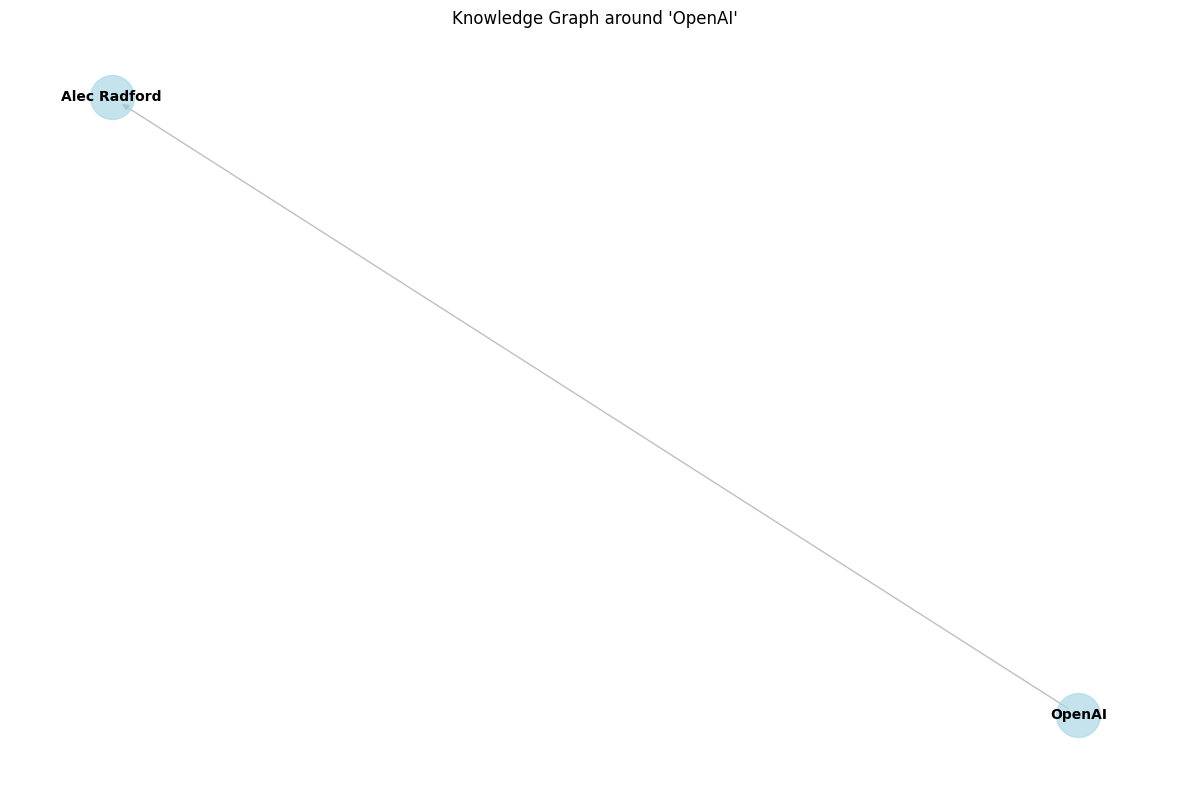

In [17]:
# Visualize specific entity relationships
entities_to_visualize = ['OpenAI', 'GPT-3', 'BERT', 'Google']

for entity in entities_to_visualize:
    if entity in kg.graph.nodes:
        print(f"\nVisualizing knowledge graph around: {entity}")
        kg.visualize_subgraph(entity, max_depth=1)
        break  # Just show one example

## 8. Advantages and Limitations

### Advantages:
1. **Contextual Understanding**: Captures relationships between entities
2. **Connected Retrieval**: Can traverse relationships to find relevant information
3. **Structured Knowledge**: Organizes information in a meaningful way
4. **Scalable**: Can handle complex domain knowledge

### Limitations:
1. **Complex Setup**: Requires entity extraction and relationship mapping
2. **Domain Dependent**: Entity extraction quality varies by domain
3. **Maintenance**: Graph needs updates as knowledge changes
4. **Computational Cost**: Graph operations can be expensive for large graphs

### When to Use Graph RAG:
- **Research domains** with clear entities and relationships
- **Scientific literature** with citations and connections
- **Legal documents** with case references
- **Knowledge bases** with structured information

## 9. Extensions and Improvements

### Possible Enhancements:
1. **Advanced NLP**: Use more sophisticated entity extraction models
2. **Graph Databases**: Integrate with Neo4j or other graph databases
3. **Dynamic Updates**: Implement incremental graph updates
4. **Weighted Relationships**: Add importance scores to relationships
5. **Multi-hop Reasoning**: Implement complex graph traversal algorithms
6. **Graph Neural Networks**: Use GNNs for better entity representations

In [ ]:
# Save the knowledge graph for later use
import pickle

def save_knowledge_graph(kg, filepath):
    """Save knowledge graph to file"""
    with open(filepath, 'wb') as f:
        pickle.dump(kg.graph, f)
    print(f"Knowledge graph saved to {filepath}")

def load_knowledge_graph(filepath):
    """Load knowledge graph from file"""
    with open(filepath, 'rb') as f:
        graph = pickle.load(f)
    return graph

# Example: Save current graph
save_knowledge_graph(kg, 'knowledge_graph.pkl')

print("\nGraph RAG implementation complete!")
print("This notebook demonstrated:")
print("- Entity extraction from documents")
print("- Knowledge graph construction")
print("- Graph-based retrieval")
print("- Contextual answer generation")
print("- Performance analysis")